In [2]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems
import tensorflow as tf


%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import global_meter_group
from nilmtk import DataSet
from nilmtk.datastore import HDFDataStore
from nilmtk.disaggregate import CO, FHMMExact
import nilmtk.utils as util
import nilmtk.metrics as met
from nilmtk.api import API

from nilmtk.disaggregate.hybdisaggregator import HYBDisaggregator



In [2]:
# Setting random seeds for reproducibility
tf.random.set_seed(0)
np.random.seed(7)

In [20]:
# Fetching the UK-DALE dataset. Alternatively it is also placed in github repository. Adding this in case, download from github fails
!curl https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2015/UK-DALE-disaggregated/ukdale.h5.tgz -o ukdale.h5.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2835M  100 2835M    0     0  5250k      0  0:09:12  0:09:12 --:--:-- 3087k


In [21]:
# Unpacking the tar file
!tar xvfz ukdale.h5.tgz

x ukdale.h5


In [23]:
#Remove archive file once extracted
!rm ukdale.h5.tgz

## Exploratory Data Analysis 

In [78]:
# Selecting top 5 electrical appliances which consume maximum power in the time window. Setting k=6 as the selection includes sitemeter as well.
top5 = DataSet('ukdale.h5')
top5.set_window(start="2014-02-17 00:00", end="2014-02-17 23:59")
top5_elec = top5.buildings[1].elec
top5_elec_appliance = top5_elec.select_top_k(k=6)

53/53 ElecMeter(instance=54, building=1, dataset='UK-DALE', site_meter, appliances=[Appliance(type='immersion heater', instance=1), Appliance(type='water pump', instance=1), Appliance(type='security alarm', instance=1), Appliance(type='fan', instance=2), Appliance(type='drill', instance=1), Appliance(type='laptop computer', instance=2)])

In [79]:
# Listing all appliances using the attribute
top5_elec_appliance.submeters()

MeterGroup(meters=
  ElecMeter(instance=12, building=1, dataset='UK-DALE', appliances=[Appliance(type='fridge freezer', instance=1)])
  ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=25, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=16)])
  ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])
)

Even though top5_elec_appliance MeterGroup has 6 ElecMeter instances, calling submeter() returns only the submteres and ignores the sitemeter

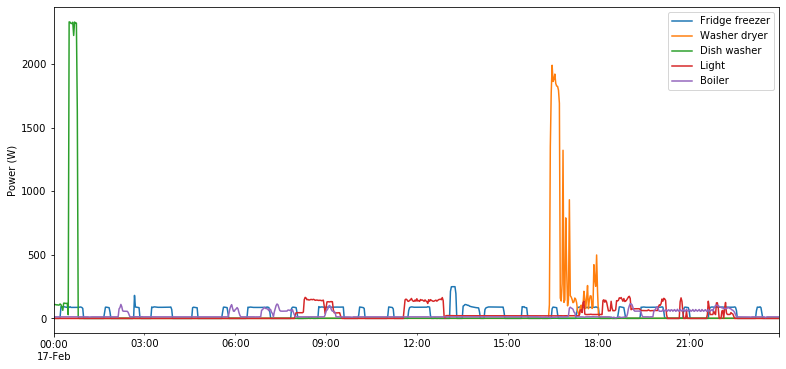

In [80]:
top5_elec_appliance.submeters().plot()

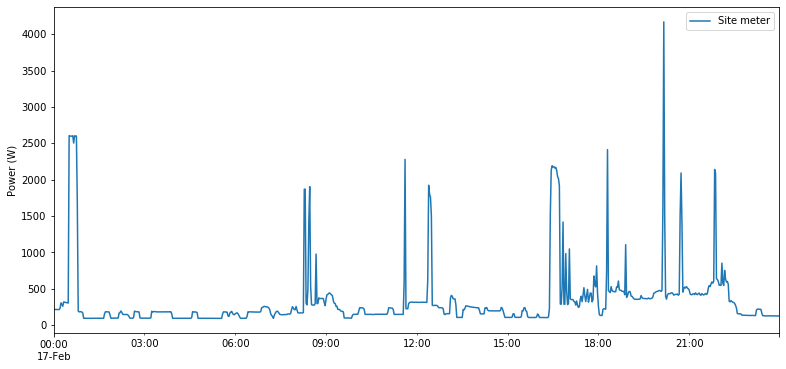

In [42]:
#Plot of aggregate signal comprising of these 5 appliances
top5_elec_appliance.mains().plot()

In [44]:
top5_elec_appliance.mains().total_energy()

active    8.026958
dtype: float64

In [47]:
top5_per_meter = top5_elec_appliance.energy_per_meter()
top5_per_meter

6/6 ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])

,"(54, 1, UK-DALE)","(12, 1, UK-DALE)","(5, 1, UK-DALE)","(6, 1, UK-DALE)","(25, 1, UK-DALE)","(2, 1, UK-DALE)"
active,8.026958,0.898588,0.873654,0.739541,NaN,NaN
apparent,NaN,NaN,NaN,NaN,0.734048,0.595687
reactive,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
top5_per_meter.columns=['Site meter','Fridge','Washer Dryer','Dish washer','Light','Boiler']

In [52]:
top5_per_meter

,Site meter,Fridge,Washer Dryer,Dish washer,Light,Boiler
active,8.026958,0.898588,0.873654,0.739541,NaN,NaN
apparent,NaN,NaN,NaN,NaN,0.734048,0.595687
reactive,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
# To find the fraction of energy consumed by the top appliances
fraction = top5_elec.submeters().fraction_per_meter().dropna()

52/52 ElecMeter(instance=53, building=1, dataset='UK-DALE', appliances=[Appliance(type='printer', instance=1)])

In [131]:
# Deriving the fractions of the energy consumption by appliance
labels = top5_elec.get_labels(fraction.index)

In [119]:
fractiondf = fraction.to_frame()
fractiondf

,0
"(2, 1, UK-DALE)",0.082592
"(3, 1, UK-DALE)",0.031005
"(5, 1, UK-DALE)",0.121132
"(6, 1, UK-DALE)",0.102537
"(7, 1, UK-DALE)",0.039254
"(8, 1, UK-DALE)",0.063853
"(9, 1, UK-DALE)",0.043293
"(10, 1, UK-DALE)",0.047574
"(11, 1, UK-DALE)",0.052858
"(12, 1, UK-DALE)",0.124589


In [120]:
fractiondf['Appliance']=np.array(labels)

In [128]:
fractiondf.set_index('Appliance',drop=True, inplace=True)

In [133]:
fractiondf.sort_values('Value',ascending=False)

,Value
Appliance,
Fridge freezer,0.124589
Washer dryer,0.121132
Dish washer,0.102537
Light,0.101776
Boiler,0.082592
Light,0.063853
Toaster,0.052858
Kettle,0.047574
Computer,0.043652


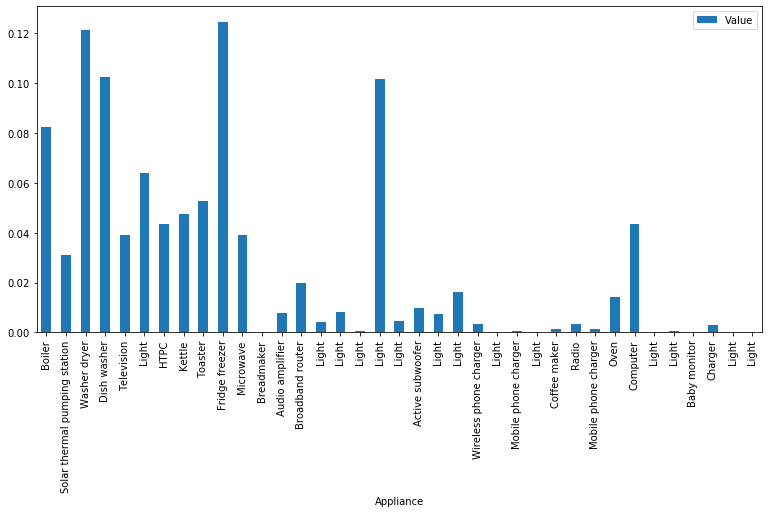

In [134]:
fractiondf.plot(kind='bar')

## Model Train and Disaggregation

In [3]:
#Importing datasets
train = DataSet('ukdale.h5')
test = DataSet('ukdale.h5')

In [4]:
train.buildings

OrderedDict([(1, Building(instance=1, dataset='UK-DALE')),
             (2, Building(instance=2, dataset='UK-DALE')),
             (3, Building(instance=3, dataset='UK-DALE')),
             (4, Building(instance=4, dataset='UK-DALE')),
             (5, Building(instance=5, dataset='UK-DALE'))])

In [6]:
#Choosing house 1
train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

In [6]:
# The dates are interpreted by Pandas, use formats YYYY-MM-DD
train_elec.get_timeframe(), test_elec.get_timeframe()

(TimeFrame(start='2012-11-09 22:28:18+00:00', end='2015-01-05 06:27:12+00:00', empty=False),
 TimeFrame(start='2012-11-09 22:28:18+00:00', end='2015-01-05 06:27:12+00:00', empty=False))

In [4]:
#Setting timeframes. Last week for testing, everything else for training.
train.set_window(start="2012-11-09", end="2014-01-01")
test.set_window(start="2014-01-01 00:00", end="2014-03-30 23:59")

In [8]:
train_elec.get_timeframe(), test_elec.get_timeframe()

(TimeFrame(start='2012-11-09 22:28:18+00:00', end='2014-01-01 00:00:00+00:00', empty=False),
 TimeFrame(start='2014-02-17 00:00:00+00:00', end='2014-02-17 23:59:00+00:00', empty=False))

In [8]:
#Checking out all the submeters in the train elecmeter group. Returns a metergroup object
train_elec

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])
  ElecMeter(instance=3, building=1, dataset='UK-DALE', appliances=[Appliance(type='solar thermal pumping station', instance=1)])
  ElecMeter(instance=4, building=1, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1), Appliance(type='laptop computer', instance=3)])
  ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=8, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=1), Appliance(type='light', instance=2)])
  ElecMeter(instance=9, building=1, dataset='UK-DALE', appliances=[Appliance(type='HTPC', instance=1)])
  Ele

In [9]:
# which ElecMeter is connected to the washer dryer?
train_elec['washer dryer']

ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1)])

In [10]:
test_elec['washer dryer'].get_activations()

[2014-01-02 14:06:36+00:00     0.0
 2014-01-02 14:06:42+00:00     7.0
 2014-01-02 14:06:48+00:00    11.0
 2014-01-02 14:06:54+00:00    11.0
 2014-01-02 14:07:00+00:00    10.0
                              ... 
 2014-01-02 15:48:48+00:00     3.0
 2014-01-02 15:48:54+00:00    84.0
 2014-01-02 15:49:00+00:00     3.0
 2014-01-02 15:49:06+00:00    75.0
 2014-01-02 15:49:12+00:00     3.0
 Freq: 6S, Name: (power, active), Length: 1027, dtype: float32,
 2014-01-02 15:59:42+00:00     6.0
 2014-01-02 15:59:48+00:00     6.0
 2014-01-02 15:59:54+00:00    10.0
 2014-01-02 16:00:00+00:00    10.0
 2014-01-02 16:00:06+00:00     3.0
                              ... 
 2014-01-02 17:39:36+00:00    88.0
 2014-01-02 17:39:42+00:00    24.0
 2014-01-02 17:39:48+00:00     3.0
 2014-01-02 17:39:54+00:00    87.0
 2014-01-02 17:40:00+00:00     3.0
 Freq: 6S, Name: (power, active), Length: 1004, dtype: float32,
 2014-01-03 14:40:06+00:00      0.0
 2014-01-03 14:40:12+00:00      0.0
 2014-01-03 14:40:18+00:00    

In [11]:
#Mains refers to the site meter ( the aggregate of all energy consumption).
train_elec.mains()

ElecMeter(instance=54, building=1, dataset='UK-DALE', site_meter, appliances=[Appliance(type='immersion heater', instance=1), Appliance(type='water pump', instance=1), Appliance(type='security alarm', instance=1), Appliance(type='fan', instance=2), Appliance(type='drill', instance=1), Appliance(type='laptop computer', instance=2)])

In the UK DALE Building 1 dataset, instance=54 refers to the site meter.

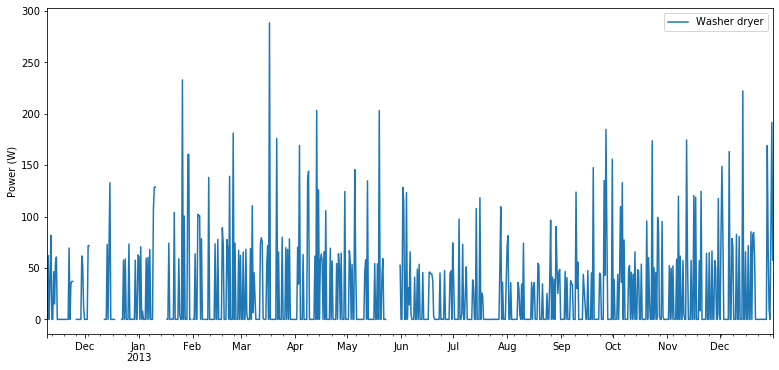

In [12]:
#Plotting the power waveform of washer dryer in the training data
train_elec['washer dryer'].plot()

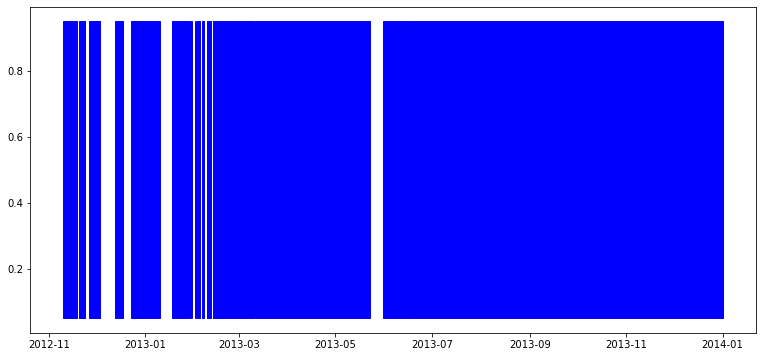

In [12]:
# Visualising the broken sections (gaps) and the good sections of the power wave (i.e sections where every pair of consecutive samples is less than the max sampling period). 
train_elec['washer dryer'].good_sections(full_results=True).plot()

We can see from the above that there are few 'gaps' indicating when the washing machine was switched off - may be due to overall power failure or taken down for maintenance or the wireless sensor missing out to register consumption data. In house 1, the sensors were regularly taken off for testing too. 

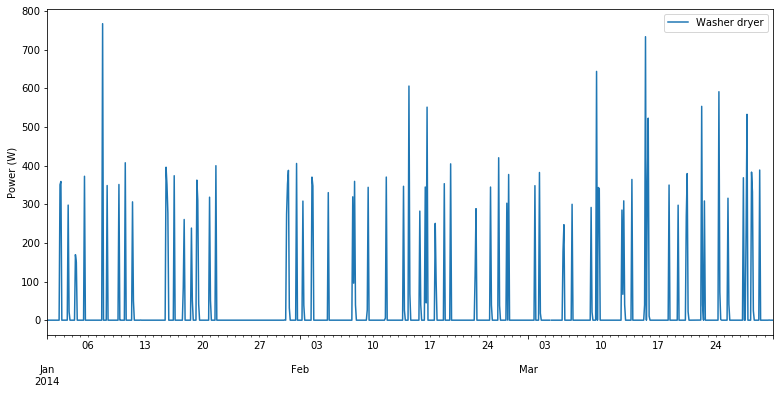

In [13]:
#The waveform we are trying to recreate
test_elec['washer dryer'].plot()

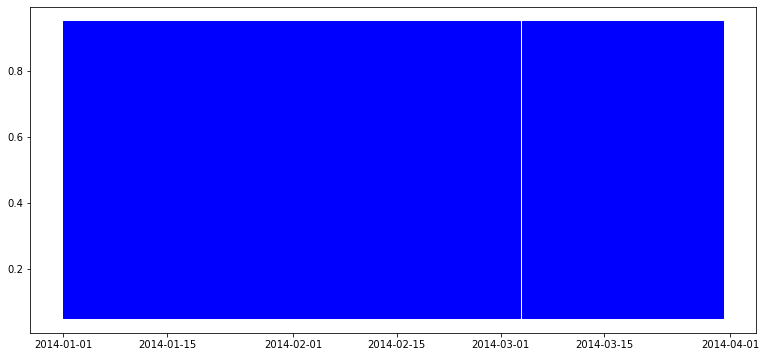

In [14]:
test_elec['washer dryer'].good_sections(full_results=True).plot()

Even though the plot is completely filled indicating full sample availability in the test data, we can see that there are still some dropouts as indicated by a non zero drop out rate.

In [7]:
train_building = 1
test_building = 1
sample_period = 6
meter_key = 'washer dryer'

In [8]:
#We want the target meter to be set on the train and test datasets
train_meter = train_elec[meter_key]
test_meter = test_elec[meter_key]

In [9]:
#Setting mains. This is the aggregated meter also called site_meter that provides the input
train_mains = train_elec.mains()
test_mains = test_elec.mains()

In [10]:
#creating the GAN instance
hyb = HYBDisaggregator(64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Sequence length is 64
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64)                739136    
_________________________________________________________________
sequential_1 (Sequential)    (None, 64)                739136    
Total params: 1,478,272
Trainable params: 1,478,272
Non-trainable params: 0
_________________________________________________________________
Model Summary None


CHECKPOINT 0
Epoch 1/15
3661/3661 [==============================] - 28s 8ms/step - loss: 4.8848e-04 - val_loss: 5.3493e-04
Epoch 2/15
3661/3661 [==============================] - 31s 9ms/step - loss: 4.4672e-04 - val_loss: 5.4777e-04
Epoch 3/15
3661/3661 [==============================] - 36s 10ms/step - loss: 4.3250e-04 - val_loss: 5.3206e-04
Epoch 4/15
3661/3661 [==============================] - 35s 10ms/step - loss: 4.2056e-04 - val_loss: 5.1262e-04
Epoch 5/15
3661/3661 [==============================] - 31s 8ms/step - loss: 3.9474e-04 - val_loss: 5.0009e-04
Epoch 6/15
3661/3661 [==============================] - 32s 9ms/step - loss: 3.8178e-04 - val_loss: 4.6105e-04
Epoch 7/15
3661/3661 [==============================] - 31s 9ms/step - loss: 3.7505e-04 - val_loss: 4.0856e-04
Epoch 8/15
3661/3661 [==============================] - 33s 9ms/step - loss: 3.7255e-04 - val_loss: 4.6354e-04
Epoch 9/15
3661/3661 [==============================] - 32s 9ms/step - loss: 3.6750e-04 - val_los

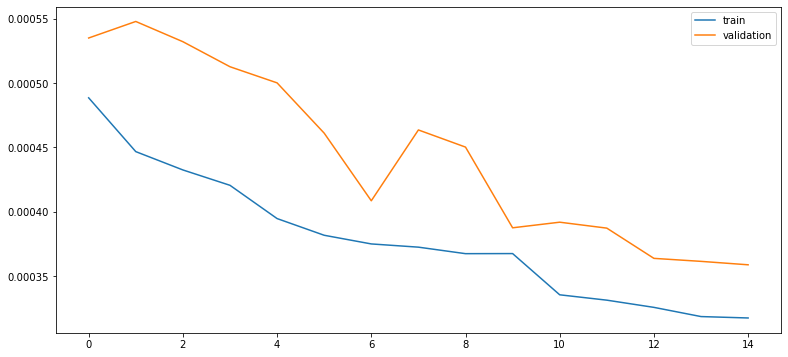

CHECKPOINT 15
Epoch 1/15
3661/3661 [==============================] - 30s 8ms/step - loss: 3.1654e-04 - val_loss: 3.5876e-04
Epoch 2/15
3661/3661 [==============================] - 29s 8ms/step - loss: 3.1542e-04 - val_loss: 3.5533e-04
Epoch 3/15
3661/3661 [==============================] - 33s 9ms/step - loss: 3.1456e-04 - val_loss: 3.5457e-04
Epoch 4/15
3661/3661 [==============================] - 39s 11ms/step - loss: 3.1322e-04 - val_loss: 3.5640e-04
Epoch 5/15
3661/3661 [==============================] - 35s 10ms/step - loss: 3.1286e-04 - val_loss: 3.5394e-04
Epoch 6/15
3661/3661 [==============================] - 40s 11ms/step - loss: 3.1205e-04 - val_loss: 3.5223e-04
Epoch 7/15
3661/3661 [==============================] - 34s 9ms/step - loss: 3.1108e-04 - val_loss: 3.5089e-04
Epoch 8/15
3661/3661 [==============================] - 38s 10ms/step - loss: 3.0917e-04 - val_loss: 3.5537e-04
Epoch 9/15
3661/3661 [==============================] - 37s 10ms/step - loss: 3.0895e-04 - val

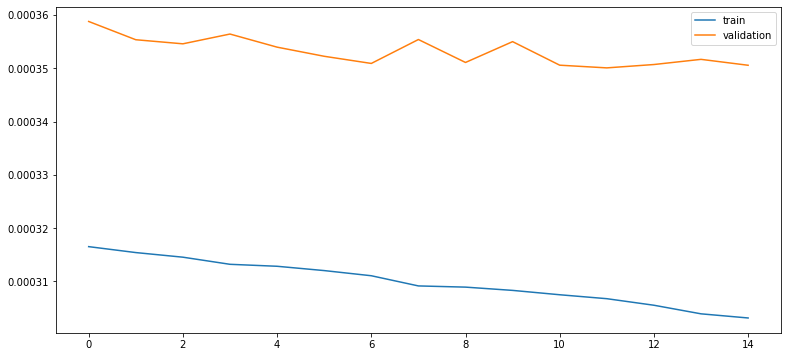

CHECKPOINT 30
Epoch 1/15
3661/3661 [==============================] - 31s 8ms/step - loss: 3.0309e-04 - val_loss: 3.5481e-04
Epoch 2/15
3661/3661 [==============================] - 32s 9ms/step - loss: 3.0213e-04 - val_loss: 3.4689e-04
Epoch 3/15
3661/3661 [==============================] - 36s 10ms/step - loss: 3.0130e-04 - val_loss: 3.4718e-04
Epoch 4/15
3661/3661 [==============================] - 35s 10ms/step - loss: 3.0078e-04 - val_loss: 3.4910e-04
Epoch 5/15
3661/3661 [==============================] - 39s 11ms/step - loss: 2.9979e-04 - val_loss: 3.4837e-04
Epoch 6/15
3661/3661 [==============================] - 36s 10ms/step - loss: 2.9970e-04 - val_loss: 3.4586e-04
Epoch 7/15
3661/3661 [==============================] - 35s 9ms/step - loss: 2.9826e-04 - val_loss: 3.4518e-04
Epoch 8/15
3661/3661 [==============================] - 38s 10ms/step - loss: 2.9681e-04 - val_loss: 3.5355e-04
Epoch 9/15
3661/3661 [==============================] - 36s 10ms/step - loss: 2.9661e-04 - va

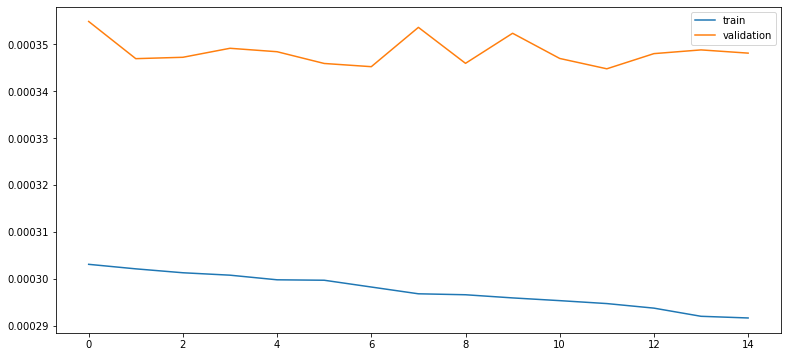

Train = 1735.0597832202911 seconds.


In [19]:
start = time.time()
#Training starts here
epochs = 0
for i in range(3):
    print("CHECKPOINT {}".format(epochs))
    hyb.train(train_mains, train_meter, epochs=15, sample_period=sample_period)
    epochs += 15
    hyb.export_model("UKDALE-HYB_bce-h{}-{}-{}epochs.h5".format(train_building,meter_key,epochs))
end = time.time()
print("Train =", end-start, "seconds.")

In [50]:
hyb.import_model('UKDALE-HYB_trainable-h1-washer dryer-45epochs.h5')

In [20]:
#Disaggregation starts here
disag_filename = "disag-hyb20140101_20140330_bce.h5"
output = HDFDataStore(disag_filename,'w')
hyb.disaggregate(test_mains, output, train_meter, sample_period=sample_period)
output.close()


Result chunk: 885036
Result chunk: 587
Result chunk: 574
Result chunk: 574
Result chunk: 390662


RESULTS


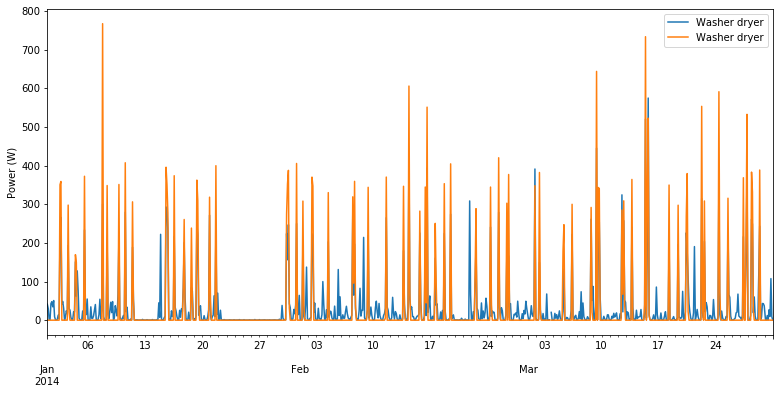

In [21]:
print("RESULTS")
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec
predicted = res_elec[meter_key]
ground_truth = test_meter

predicted.plot()
ground_truth.plot()
plt.show()

mets = met.recall_precision_accuracy_f1_bacc(predicted, ground_truth)
report = pd.DataFrame()

result = {
      "Recall": mets[0],
      "Precision": mets[1],
      "Accuracy": mets[2],
      "F1 Score": mets[3],
      "BACC": mets[4],
      "Relative error in total energy":(met.relative_error_total_energy(predicted, ground_truth)),
      "Mean absolute error(in Watts)":(met.mean_absolute_error(predicted, ground_truth))}
row = pd.Series(result,name='Washer Dryer')
report = report.append(row)
rmse = met.rmse(predicted,ground_truth)

In [24]:
report

,Accuracy,BACC,F1 Score,Mean absolute error(in Watts),Precision,Recall,Relative error in total energy
Washer Dryer,0.711766,0.580498,0.337256,31.047776,0.318617,0.358211,0.14028


In [25]:
# Trialling on a single day e.g. 2014-02-17 used in examples in the report
test.set_window(start="2014-02-17 00:00", end="2014-02-17 23:59")

In [26]:
test_elec = test.buildings[1].elec

In [27]:
test_meter=test_elec[meter_key]
test_mains = test_elec.mains()

In [28]:
#creating the GAN instance
hyb = HYBDisaggregator(64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Sequence length is 64
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 64)                739136    
_________________________________________________________________
sequential_4 (Sequential)    (None, 64)                739136    
Total params: 1,478,272
Trainable params: 1,478,272
Non-trainable params: 0
_________________________________________________________________
Model Summary None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv

In [29]:
#Import the trained model
hyb.import_model('UKDALE-HYB_bce-h1-washer dryer-45epochs.h5')

In [30]:
#Disaggregation starts here
disag_filename = "disag-hyb20140217_20140217_bce.h5"
output = HDFDataStore(disag_filename,'w')
hyb.disaggregate(test_mains, output, train_meter, sample_period=sample_period)
output.close()

Result chunk: 14390


RESULTS


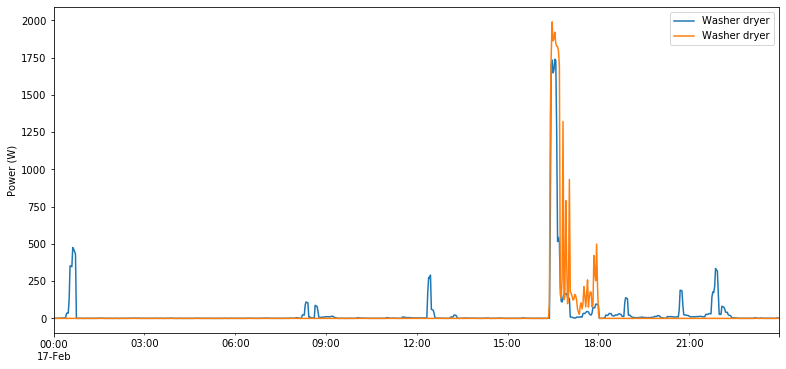

In [31]:
print("RESULTS")
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec
predicted = res_elec[meter_key]
ground_truth = test_meter

predicted.plot()
ground_truth.plot()
plt.show()

mets = met.recall_precision_accuracy_f1_bacc(predicted, ground_truth)
report = pd.DataFrame()

result = {
      "Recall": mets[0],
      "Precision": mets[1],
      "Accuracy": mets[2],
      "F1 Score": mets[3],
      "BACC": mets[4],
      "Relative error in total energy":(met.relative_error_total_energy(predicted, ground_truth)),
      "Mean absolute error(in Watts)":(met.mean_absolute_error(predicted, ground_truth))}
row = pd.Series(result,name='Washer Dryer')
report = report.append(row)
rmse = met.rmse(predicted,ground_truth)

In [32]:
report

,Accuracy,BACC,F1 Score,Mean absolute error(in Watts),Precision,Recall,Relative error in total energy
Washer Dryer,0.704239,0.573933,0.335,31.394017,0.326332,0.344141,0.054542


In [5]:
# Trialling on a full year e.g. 2014-02-17 used in examples in the report
train.set_window(start="2012-11-09", end="2014-01-01")
test.set_window(start="2014-01-05 00:00", end="2015-01-05 23:59")

In [11]:
test_elec = test.buildings[1].elec

In [12]:
test_meter=test_elec[meter_key]
test_mains = test_elec.mains()

In [13]:
#creating the GAN instance
hyb = HYBDisaggregator(64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Sequence length is 64
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 64)                739136    
_________________________________________________________________
sequential_4 (Sequential)    (None, 64)                739136    
Total params: 1,478,272
Trainable params: 1,478,272
Non-trainable params: 0
_________________________________________________________________
Model Summary None


In [14]:
hyb.import_model('UKDALE-HYB_bce-h1-washer dryer-45epochs.h5')

In [15]:
#Disaggregation starts here
disag_filename = "disag-hyb20140105_20150105_bce.h5"
output = HDFDataStore(disag_filename,'w')
hyb.disaggregate(test_mains, output, train_meter, sample_period=sample_period)
output.close()

Result chunk: 827436
Result chunk: 587
Result chunk: 574
Result chunk: 574
Result chunk: 2008672
Result chunk: 928669
Result chunk: 1483912


RESULTS


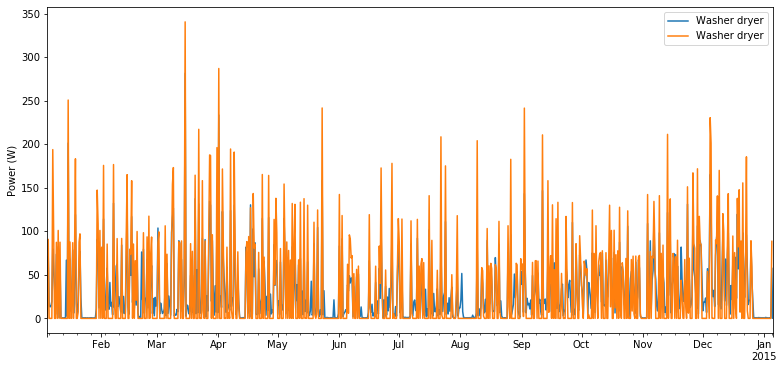

In [16]:
print("RESULTS")
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec
predicted = res_elec[meter_key]
ground_truth = test_meter

predicted.plot()
ground_truth.plot()
plt.show()

mets = met.recall_precision_accuracy_f1_bacc(predicted, ground_truth)
report = pd.DataFrame()

result = {
      "Recall": mets[0],
      "Precision": mets[1],
      "Accuracy": mets[2],
      "F1 Score": mets[3],
      "BACC": mets[4],
      "Relative error in total energy":(met.relative_error_total_energy(predicted, ground_truth)),
      "Mean absolute error(in Watts)":(met.mean_absolute_error(predicted, ground_truth))}
row = pd.Series(result,name='Washer Dryer')
report = report.append(row)
rmse = met.rmse(predicted,ground_truth)

In [17]:
report

,Accuracy,BACC,F1 Score,Mean absolute error(in Watts),Precision,Recall,Relative error in total energy
Washer Dryer,0.727275,0.591632,0.348326,30.921666,0.331998,0.366343,0.118768


### The below sections are for informational purposes only and not included in the report. This is an attempt to test the models on building 2, but still needs some work as house 2 power from source data seem like reactive power that needs to be verified. Surely the washing machine cannot consume between 3 and 4w of power. Since the model was trained on active power, it does not make sense to use it to predict reactive power.

In [55]:
test_unseen = DataSet('ukdale.h5')

In [56]:
test_unseen.set_window(start="2013-09-15 00:00", end="2013-09-15 23:59")

In [57]:
test_unseen_elec = test_unseen.buildings[2].elec

In [58]:
test_unseen_meter = test_unseen_elec['washer dryer']

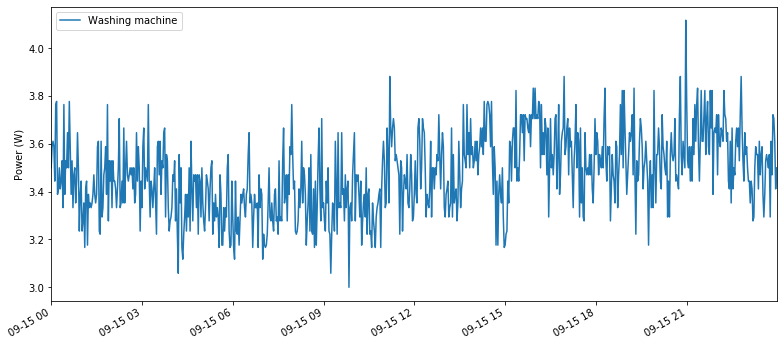

In [59]:
test_unseen_meter.plot()

In [60]:
test_unseen_mains = test_unseen_elec.mains()

In [61]:
#creating the GAN instance
hyb = HYBDisaggregator(64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Sequence length is 64
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 64)                739136    
_________________________________________________________________
sequential_13 (Sequential)   (None, 64)                739136    
Total params: 1,478,272
Trainable params: 1,478,272
Non-trainable params: 0
_________________________________________________________________
Model Summary None
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Con

In [62]:
#Load trained model
hyb.import_model('UKDALE-HYB_trainable-h1-washer dryer-45epochs.h5')

In [63]:
#Disaggregation starts here
disag_filename = "disag-hyb20130915_unseen-64-out.h5"
output = HDFDataStore(disag_filename,'w')
hyb.disaggregate(test_unseen_mains, output, test_unseen_meter, sample_period=6)
output.close()

Result chunk: 14390


RESULTS


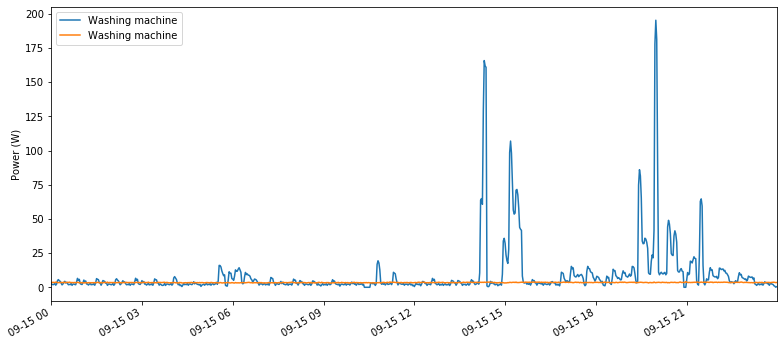

In [64]:
print("RESULTS")
result = DataSet(disag_filename)
res_elec = result.buildings[2].elec
predicted = res_elec['washer dryer']
ground_truth = test_unseen_meter

predicted.plot()
ground_truth.plot()
plt.show()

mets = met.recall_precision_accuracy_f1_bacc(predicted, ground_truth)
report = pd.DataFrame()

result = {
      "Recall": mets[0],
      "Precision": mets[1],
      "Accuracy": mets[2],
      "F1 Score": mets[3],
      "BACC": mets[4],
      "Relative error in total energy":(met.relative_error_total_energy(predicted, ground_truth)),
      "Mean absolute error(in Watts)":(met.mean_absolute_error(predicted, ground_truth))}
row = pd.Series(result,name='Washer Dryer')
report = report.append(row)
rmse = met.rmse(predicted,ground_truth)

In [66]:
report

,Accuracy,BACC,F1 Score,Mean absolute error(in Watts),Precision,Recall,Relative error in total energy
Washer Dryer,0.802502,0.500899,0.046948,7.123641,0.026944,0.182292,0.624087


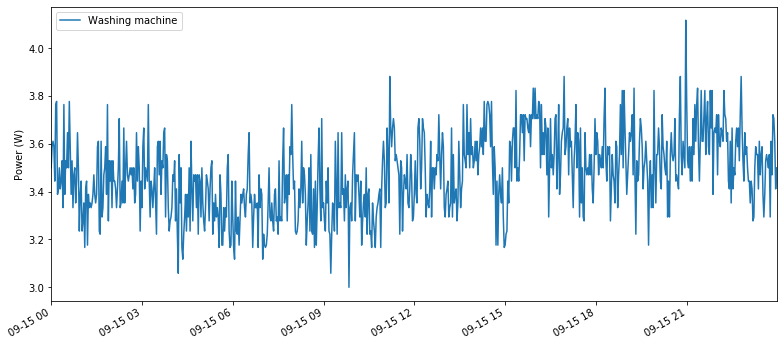

In [68]:
ground_truth.plot()

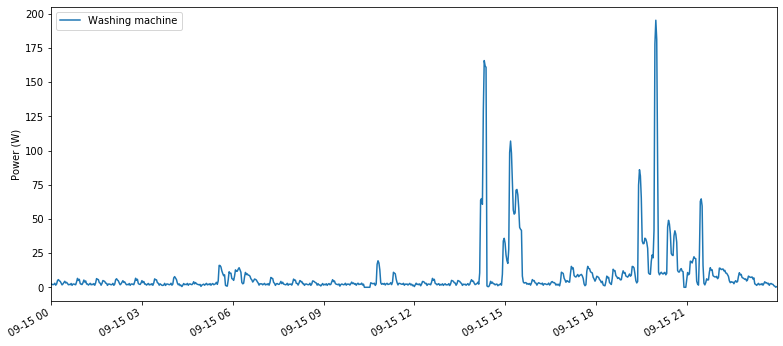

In [67]:
predicted.plot()